# Simulation Experiments: Computational Validation of GENERIC Structure

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lawrennd/the-inaccessible-game/blob/main/simulation_experiments_inaccessible_game.ipynb)

## Neil D. Lawrence

### October 2025

This notebook generates all computational results and figures for simulation studies in "The Inaccessible Game" paper.

*System:* Three binary variables with pairwise interactions (Ising model / Boltzmann machine)

*Goal:* Validate theoretical predictions:

- GENERIC decomposition $M = S + A$ emerges from constraint geometry
- Marginal entropy conservation ($\sum_i h_i = C$) is maintained during evolution
- Constrained vs unconstrained dynamics behave differently
- Regime variation $\tfrac{\|A\|}{\|S\|}$ depends on local geometry


In [ ]:
# Setup cell for Google Colab compatibility
import sys
import os

# Check if we're running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Running in Google Colab - setting up environment...")
    
    # Clone the repository if not already present
    if not os.path.exists('the-inaccessible-game'):
        !git clone https://github.com/lawrennd/the-inaccessible-game.git
        print("✓ Repository cloned")
    
    # Change to repo directory
    os.chdir('the-inaccessible-game')
    
    # Install dependencies
    !pip install -q numpy scipy matplotlib
    print("✓ Dependencies installed")
    
    # Add repo to Python path so we can import modules
    if os.getcwd() not in sys.path:
        sys.path.insert(0, os.getcwd())
    
    print("✓ Setup complete! You can now run the notebook.")
else:
    print("💻 Running locally - no setup needed")


# Initial Setup


In [30]:
import matplotlib.pyplot as plt

In [31]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'default')
big_wide_figsize = (10, 5)
big_figsize = (8, 8)
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 'medium',
})

In [32]:
verbose = False
N = 3  # Three binary variables

print(f"System: {N} binary variables with pairwise interactions")
print(f"Parameter space dimension: d = {N + N*(N-1)//2} (marginals + interactions)")

System: 3 binary variables with pairwise interactions
Parameter space dimension: d = 6 (marginals + interactions)


In [33]:
import numpy as np
import generic_decomposition_n3 as gd

Random initial parameters (for initial demonstration)


In [34]:
h = 0 # Set external field
theta_frustrated = np.array([h, h, h, 1, -1, 1]) # Set frustrated parameters
theta_frustrated = theta_frustrated/np.sqrt(theta_frustrated.T@theta_frustrated) # normalise

In [35]:
print(f"  θ₁, θ₂, θ₃ = {theta_frustrated[:3]}")
print(f"  θ₁₂, θ₁₃, θ₂₃ = {theta_frustrated[3:]}")

  θ₁, θ₂, θ₃ = [0. 0. 0.]
  θ₁₂, θ₁₃, θ₂₃ = [ 0.57735027 -0.57735027  0.57735027]


In [36]:
# Compute initial constraint value
marginals, _ = gd.compute_marginals(theta_frustrated, N)
C_init = sum(gd.marginal_entropy(m) for m in marginals)

In [37]:
print(f"\nInitial marginal entropies:")
for i, m in enumerate(marginals, 1):
    print(f"  h_{i} = {gd.marginal_entropy(m):.4f}")
print(f"\nConstraint value: C = Σh_i = {C_init:.6f}")
print(f"Maximum possible: {N*np.log(2):.6f} (uniform distribution)")


Initial marginal entropies:
  h_1 = 0.6925
  h_2 = 0.6532
  h_3 = 0.6925

Constraint value: C = Σh_i = 2.038252
Maximum possible: 2.079442 (uniform distribution)


In [38]:
result = gd.analyse_generic_structure(theta_frustrated, N)

In [39]:
print(f"  Jacobian M = S + A")
print(f"  ||S|| = {result['norm_S']:.3f} (dissipative, symmetric)")
print(f"  ||A|| = {result['norm_A']:.3f} (conservative, antisymmetric)")
print(f"  ||A||/||S|| = {result['ratio']:.3f}")

  Jacobian M = S + A
  ||S|| = 0.093 (dissipative, symmetric)
  ||A|| = 0.015 (conservative, antisymmetric)
  ||A||/||S|| = 0.160


# Vary Temperature

In this experiment we scale the parameters to change the temperature of the system and monitor the ratio between the antisymmetric and symmetric parts.

In [40]:
theta = theta_frustrated
temp_values = np.logspace(-1.5, 1.5, 200) 
beta_values = 1/temp_values
ratios_temp = []
norms_S_temp = []
norms_A_temp = []

print("Computing ||A||/||S|| for β ∈ [0.1, 3.0]...")
for i, beta in enumerate(beta_values):
    theta_scaled = beta * theta
    try:
        result_temp = gd.analyse_generic_structure(theta_scaled, N)
        ratios_temp.append(result_temp['ratio'])
        norms_S_temp.append(result_temp['norm_S'])
        norms_A_temp.append(result_temp['norm_A'])
        if (i+1) % 5 == 0 and verbose:
            print(f"  β = {beta:.2f}: ||A||/||S|| = {result_temp['ratio']:.3f}, ||S|| = {result_temp['norm_S']:.3f}, ||A|| = {result_temp['norm_A']:.3f}")
    except:
        ratios_temp.append(np.nan)
        norms_S_temp.append(np.nan)
        norms_A_temp.append(np.nan)
        print(f"  β = {beta:.2f}: Failed")

ratios_temp = np.array(ratios_temp)
norms_S_temp = np.array(norms_S_temp)
norms_A_temp = np.array(norms_A_temp)

# Find peak
valid_mask = ~np.isnan(ratios_temp)
peak_idx = np.argmax(ratios_temp[valid_mask])
peak_beta = beta_values[valid_mask][peak_idx]
peak_ratio = ratios_temp[valid_mask][peak_idx]

print(f"  Peak ratio: ||A||/||S|| = {peak_ratio:.3f}")
print(f"  Peak location: β = {peak_beta:.2f}")
print(f"  Low temperature (β={beta_values[0]:.3f}): ||A||/||S|| = {ratios_temp[0]:.3f}")
print(f"  High temperature (β={beta_values[-1]:.3f}): ||A||/||S|| = {ratios_temp[-1]:.3f}")


Computing ||A||/||S|| for β ∈ [0.1, 3.0]...
  Peak ratio: ||A||/||S|| = 0.352
  Peak location: β = 4.85
  Low temperature (β=31.623): ||A||/||S|| = 0.000
  High temperature (β=0.032): ||A||/||S|| = 0.221


Plot the Frobenius norms of the antisymmetric and symmetric components.

In [41]:
import matplotlib.pyplot as plt

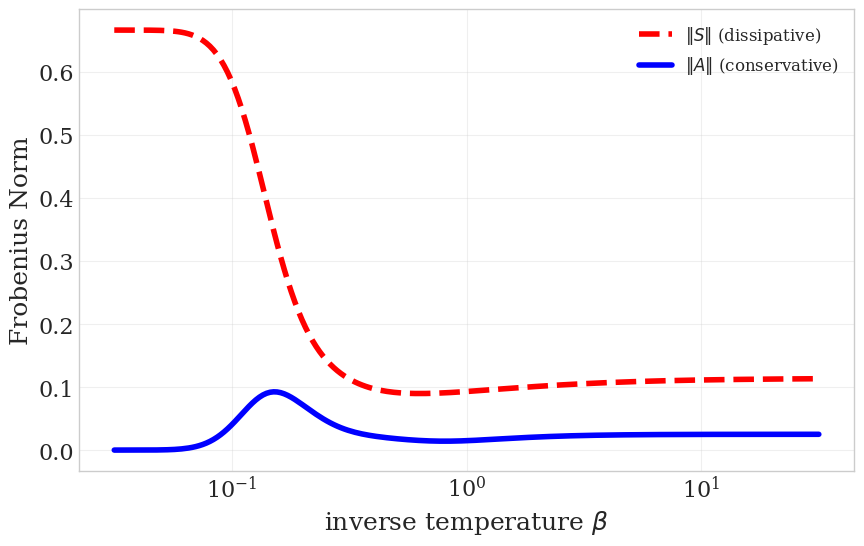

In [42]:
# generate component norms separately vs temperature
fig, ax = plt.subplots(figsize=gd.big_wide_figsize)
ax.semilogx(temp_values, norms_S_temp[valid_mask], 'r--', linewidth=4, 
        label=r'$\|S\|$ (dissipative)')
ax.semilogx(temp_values, norms_A_temp[valid_mask], 'b-', linewidth=4, 
        label=r'$\|A\|$ (conservative)')
ax.set_xlabel(r'inverse temperature $\beta$')
ax.set_ylabel('Frobenius Norm')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.savefig('./diagrams/fig-n3_coldness-vs-component_norms.pdf', bbox_inches='tight', dpi=300)

Plot the ratio of the Frobenius norms vs inverse temperature ($\beta$)

In [ ]:
# Plot ratio vs β 
beta_values = 1.0 / temp_values[valid_mask]  # β^-1 ∝ T

fig, ax = plt.subplots(figsize=gd.big_wide_figsize)
ax.semilogx(temp_values, ratios_temp[valid_mask], 'b-', linewidth=4)
peak_temp = 1.0 / peak_beta
ax.axvline(peak_temp, color='r', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel(r'inverse temperature $\beta$')
ax.set_ylabel(r'$\|A\|/\|S\|$')
ax.grid(True, alpha=0.3)
ax.text(peak_temp, peak_ratio*1.1, f'Peak: β={peak_temp:.2f}', 
        ha='center', fontsize=16)

plt.savefig('./diagrams/fig-n3_coldness-vs-ratio.pdf', bbox_inches='tight', dpi=300)

# Experiment 2: Constraint Maintenance During Evolution

Compare constrained dynamics (with $\sum_i h_i = C$) to unconstrained
maximum entropy production (pure gradient ascent on $H$).



In [ ]:
sol_constrained = gd.solve_constrained_maxent(
    theta_frustrated, N=3, n_steps=40000, dt=0.01, verbose=verbose
)

Summary of the constrained dynamics.

In [ ]:
print(f"  Converged: {sol_constrained['converged']}")
print(f"  Steps: {sol_constrained['n_steps']}")
print(f"  Final ||F(θ)||: {sol_constrained['flow_norms'][-1]:.2e}")
print(f"  Final constraint violation: |ΔC| = {abs(sol_constrained['constraint_values'][-1] - C_init):.2e}")
print(f"  Initial sum of marginals = {sol_constrained['constraint_values'][0]}")
print(f"  Initial sum of marginals = {sol_constrained['constraint_values'][-1]}")


# Experiment 3: Constrained vs Unconstrained Comparison

Integrating unconstrained dynamics from same initial condition...

(Pure maximum entropy production without constraint)

**Trajectory comparison**

-   Both start from same initial condition

-   Unconstrained converges to $\boldsymbol{\theta} = \mathbf{0}$
    (maximum entropy state)

-   Constrained converges to different point on manifold
    $\{\boldsymbol{\theta}: \sum_i h_i = C\}$

-   Demonstrates how constraint shapes parameter space flow

**Entropy evolution**

-   Both increase joint entropy $H(X_1,X_2,X_3)$ (second law holds)

-   Only constrained preserves $\sum_i h_i = C$ exactly

-   Unconstrained allows $\sum_i h_i \to \text{maximum}$ (independent
    distribution)

-   Different rates of entropy production due to constraint



In [ ]:
sol_unconstrained = gd.solve_unconstrained_maxent(
    theta_frustrated, N=3, n_steps=40000, dt=0.01, verbose=verbose
)

In [ ]:
print(f"\nUnconstrained Dynamics Summary:")
print(f"  Converged: {sol_unconstrained['converged']}")
print(f"  Steps: {sol_unconstrained['n_steps']}")
print(f"  Final ||F(θ)||: {sol_unconstrained['flow_norms'][-1]:.2e}")
print(f"  Final ||θ||: {np.linalg.norm(sol_unconstrained['trajectory'][-1]):.3f}")

Compare final states between constrated and unconstrained.

In [ ]:
theta_final_c = sol_constrained['trajectory'][-1]
theta_final_u = sol_unconstrained['trajectory'][-1]

print(f"  Constrained:   ||θ|| = {np.linalg.norm(theta_final_c):.3f}")
print(f"  Unconstrained: ||θ|| = {np.linalg.norm(theta_final_u):.3f}")


In [ ]:
# Compute final entropies
marginals_c, _ = gd.compute_marginals(theta_final_c, N)
marginals_u, _ = gd.compute_marginals(theta_final_u, N)


Compare final marginal entropy sums.

In [ ]:
C_final_c = sum(gd.marginal_entropy(m) for m in marginals_c)
C_final_u = sum(gd.marginal_entropy(m) for m in marginals_u)

print(f"\nFinal marginal entropy sums:")
print(f"  Constrained:   Σh_i = {C_final_c:.6f} (= C_init)")
print(f"  Unconstrained: Σh_i = {C_final_u:.6f} (≠ C_init)")

In [ ]:
traj_c = sol_constrained['trajectory']
traj_u = sol_unconstrained['trajectory']

In [ ]:
# %load -s save_trajectory_comparison /Users/neil/lawrennd/the-inaccessible-game/generic_decomposition_n3.py
fig, ax = plt.subplots(figsize=gd.big_figsize)

# Plot trajectories
ax.plot(traj_u[:, 0], traj_u[:, 1], 'r--', alpha=0.6, linewidth=4, 
        label='Unconstrained')
ax.plot(traj_c[:, 0], traj_c[:, 1], 'b-', alpha=0.7, linewidth=4,
        label='Constrained')

# Mark initial and final points
ax.plot(traj_c[0, 0], traj_c[0, 1], 'go', markersize=12, 
        label='Initial', zorder=5)
ax.plot(traj_u[-1, 0], traj_u[-1, 1], 'r*', markersize=16, zorder=5)
ax.plot(traj_c[-1, 0], traj_c[-1, 1], 'bs', markersize=12, zorder=5)

ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.3)
ax.axvline(0, color='k', linewidth=1, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('./diagrams/fig_trajectory_comparison.pdf', bbox_inches='tight', dpi=300)


In [ ]:
# %load -s save_trajectory_comparison /Users/neil/lawrennd/the-inaccessible-game/generic_decomposition_n3.py
fig, ax = plt.subplots(figsize=gd.big_figsize)

# Plot trajectories
ax.plot(traj_u[:, 3], traj_u[:, 4], 'r--', alpha=0.6, linewidth=4, 
        label='Unconstrained')
ax.plot(traj_c[:, 3], traj_c[:, 4], 'b-', alpha=0.7, linewidth=4,
        label='Constrained')

# Mark initial and final points
ax.plot(traj_c[0, 3], traj_c[0, 4], 'go', markersize=12, 
        label='Initial', zorder=5)
ax.plot(traj_u[-1, 3], traj_u[-1, 4], 'r*', markersize=16, zorder=5)
ax.plot(traj_c[-1, 3], traj_c[-1, 4], 'bs', markersize=12, zorder=5)

ax.set_xlabel(r'$\theta_{12}$')
ax.set_ylabel(r'$\theta_{13}$')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.3)
ax.axvline(0, color='k', linewidth=1, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('./diagrams/fig_trajectory_interaction_comparison.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# %load -s save_marginal_entropy_evolution /Users/neil/lawrennd/the-inaccessible-game/generic_decomposition_n3.py
fig, ax = plt.subplots(figsize=gd.big_wide_figsize)

# Compute marginal entropy sum for both
steps_u, sum_h_u = gd.compute_marginal_entropy_trajectory(sol_unconstrained['trajectory'], N, sample_every=1)
steps_c, sum_h_c = gd.compute_marginal_entropy_trajectory(sol_constrained['trajectory'], N, sample_every=1)

ax.plot(steps_u, sum_h_u, 'r--', linewidth=4, label='Unconstrained')
ax.plot(steps_c, sum_h_c, 'b-', linewidth=4, label='Constrained')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\sum_i h_i$')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./diagrams/fig_marginal_entropy_evolution.pdf', bbox_inches='tight', dpi=300)


In [ ]:
# %load -s save_joint_entropy_evolution /Users/neil/lawrennd/the-inaccessible-game/generic_decomposition_n3.py

fig, ax = plt.subplots(figsize=gd.big_wide_figsize)

# Compute joint entropy for both trajectories
steps_u, H_u = gd.compute_joint_entropy_trajectory(sol_unconstrained['trajectory'], N, sample_every=1)
steps_c, H_c = gd.compute_joint_entropy_trajectory(sol_constrained['trajectory'], N, sample_every=1)

ax.plot(steps_u, H_u, 'r--', linewidth=4, label='Unconstrained')
ax.plot(steps_c, H_c, 'b-', linewidth=4, label='Constrained')
ax.axhline(N*np.log(2), color='k', linestyle='--', linewidth=2, 
           alpha=0.5, label='Maximum')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$H(X_1,X_2,X_3)$')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./diagrams/fig_joint_entropy_evolution.pdf', bbox_inches='tight', dpi=300)


# Plot External Field Parameters

Plot of $\theta_1$ against $\theta_3$. The behaviour of $\theta_3$ is identical to $\theta_1$. 

In [ ]:
fig, ax = plt.subplots(figsize=gd.big_wide_figsize)

traj_u = sol_unconstrained['trajectory']
traj_c = sol_constrained['trajectory']

steps_u = np.arange(len(traj_u))
steps_c = np.arange(len(traj_c))

labels = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
colors = ['C0', 'C1', 'C2']

for i, (label, color) in enumerate(zip(labels, colors)):
    if i == 2: # don't plot theta_3
        continue
    ax.plot(steps_u, traj_u[:, i], '--', alpha=0.5, linewidth=3, 
            color=color, label=f'{label} (unc.)')
    ax.plot(steps_c, traj_c[:, i], '-', linewidth=4, 
            color=color, label=f'{label} (con.)')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel('parameter value')
ax.legend(fontsize=14, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('./diagrams/fig_marginal_parameters.pdf', bbox_inches='tight', dpi=300)


# Plot Interaction Parameters


Plot of $\theta_{12}$ against $\theta_{13}$. The behaviour of $\theta_{23}$ is identical to $\theta_{12}$. 

In [ ]:
fig, ax = plt.subplots(figsize=gd.big_wide_figsize)
    
traj_u = sol_unconstrained['trajectory']
traj_c = sol_constrained['trajectory']

steps_u = np.arange(len(traj_u))
steps_c = np.arange(len(traj_c))

labels = [r'$\theta_{12}$', r'$\theta_{13}$', r'$\theta_{23}$']
colors = ['C0', 'C1', 'C2']

for i, (label, color) in enumerate(zip(labels, colors)):
    if i == 2:
        continue
    param_idx = 3 + i  # Interaction parameters start at index 3
    ax.plot(steps_u, traj_u[:, param_idx], '--', alpha=0.5, linewidth=3,
            color=color, label=f'{label} (unc.)')
    ax.plot(steps_c, traj_c[:, param_idx], '-', linewidth=4,
            color=color, label=f'{label} (con.)')

ax.set_xlabel('$\tau$')
ax.set_ylabel('parameter value')
ax.legend(fontsize=14, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('./diagrams/fig_interaction_parameters.pdf', bbox_inches='tight', dpi=300)
